In [1]:
from chembl_webresource_client.new_client import new_client

# List of drugs
drugs = [
    "Tolnaftate", "Methotrexate", "Lisuride", "Vardenafil", "Fluspirilene",
    "Sofosbuvir", "Vorapaxar", "Olaparib", "Alatrofloxacin", "Lasmiditan",
    "Bictegravir", "Atogepant"
]

# Function to get SMILES from ChEMBL
def get_smiles(drug_name):
    try:
        molecule = new_client.molecule.filter(pref_name__iexact=drug_name).only('molecule_structures')[0]
        if molecule:
            return molecule['molecule_structures']['canonical_smiles']
        else:
            return None
    except Exception as e:
        print(f"Error retrieving SMILES for {drug_name}: {e}")
        return None

# Retrieve SMILES for each drug
drug_smiles = {}
for drug in drugs:
    smiles = get_smiles(drug)
    if smiles:
        drug_smiles[drug] = smiles
    else:
        print(f"SMILES not found for {drug}")

# Display the SMILES
for drug, smiles in drug_smiles.items():
    print(f"{drug}: {smiles}")

Tolnaftate: Cc1cccc(N(C)C(=S)Oc2ccc3ccccc3c2)c1
Methotrexate: CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1
Lisuride: CCN(CC)C(=O)N[C@H]1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1
Vardenafil: CCCc1nc(C)c2c(=O)nc(-c3cc(S(=O)(=O)N4CCN(CC)CC4)ccc3OCC)[nH]n12
Fluspirilene: O=C1NCN(c2ccccc2)C12CCN(CCCC(c1ccc(F)cc1)c1ccc(F)cc1)CC2
Sofosbuvir: CC(C)OC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@@H](n2ccc(=O)[nH]c2=O)[C@](C)(F)[C@@H]1O)Oc1ccccc1
Vorapaxar: CCOC(=O)N[C@@H]1CC[C@@H]2[C@@H](C1)C[C@H]1C(=O)O[C@H](C)[C@H]1[C@H]2/C=C/c1ccc(-c2cccc(F)c2)cn1
Olaparib: O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCN(C(=O)C2CC2)CC1
Alatrofloxacin: C[C@H](N)C(=O)N[C@@H](C)C(=O)N[C@H]1[C@@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)cc3F)C[C@@H]21
Lasmiditan: CN1CCC(C(=O)c2cccc(NC(=O)c3c(F)cc(F)cc3F)n2)CC1
Bictegravir: O=C(NCc1c(F)cc(F)cc1F)c1cn2c(c(O)c1=O)C(=O)N1[C@H]3CC[C@H](C3)O[C@@H]1C2
Atogepant: C[C@@H]1[C@H](c2c(F)ccc(F)c2F)C[C@H](NC(=O)c2cnc3c(c2)C[C@@]2(C3)C(=O)Nc3ncccc32)C(=O)N1CC(F)(F)F


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    mw = Descriptors.MolWt(mol)
    return logp, tpsa, mw

# Create a DataFrame to store the data
data = []
for drug, smiles in drug_smiles.items():
    logp, tpsa, mw = calculate_descriptors(smiles)
    data.append([drug, smiles, logp, tpsa, mw])

df = pd.DataFrame(data, columns=["Drug", "SMILES", "LogP", "TPSA", "MW"])

In [4]:
def estimate_pgp_efflux(logp, tpsa):
    if logp > 4 and tpsa < 75:
        return 1  # Likely P-gp substrate
    else:
        return 0  # Not a P-gp substrate

# Apply the rule to the DataFrame
df["P-gp_Efflux"] = df.apply(lambda row: estimate_pgp_efflux(row["LogP"], row["TPSA"]), axis=1)

  Using cached attrs-21.4.0-py2.py3-none-any.whl.metadata (9.8 kB)
Using cached attrs-21.4.0-py2.py3-none-any.whl (60 kB)
  Attempting uninstall: attrs
    Found existing installation: attrs 25.3.0
    Uninstalling attrs-25.3.0:
      Successfully uninstalled attrs-25.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jsonschema 4.23.0 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.
referencing 0.36.2 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.
hypothesis 6.130.6 requires attrs>=22.2.0, but you have attrs 21.4.0 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Tolnaftate: Cc1cccc(N(C)C(=S)Oc2ccc3ccccc3c2)c1
Methotrexate: CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1
Lisuride: CCN(CC)C(=O)N[C@H]1C=C2c3ccc

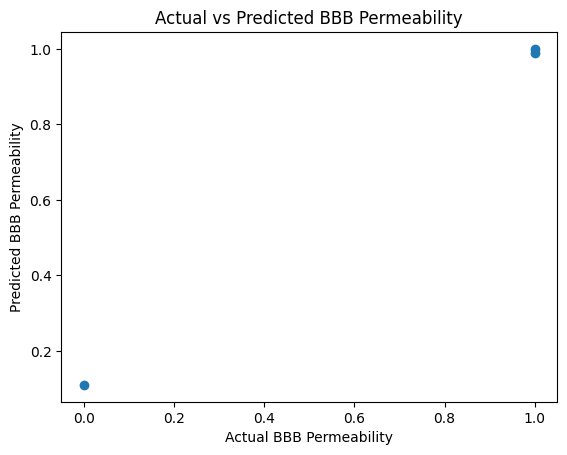

In [5]:
# Install required libraries
!pip install chembl_webresource_client rdkit scikit-learn pandas numpy

# Import libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Retrieve SMILES from ChEMBL
from chembl_webresource_client.new_client import new_client

# List of drugs
drugs = [
    "Tolnaftate", "Methotrexate", "Lisuride", "Vardenafil", "Fluspirilene",
    "Sofosbuvir", "Vorapaxar", "Olaparib", "Alatrofloxacin", "Lasmiditan",
    "Bictegravir", "Atogepant"
]

# Function to get SMILES from ChEMBL
def get_smiles(drug_name):
    try:
        molecule = new_client.molecule.filter(pref_name__iexact=drug_name).only('molecule_structures')[0]
        if molecule:
            return molecule['molecule_structures']['canonical_smiles']
        else:
            return None
    except Exception as e:
        print(f"Error retrieving SMILES for {drug_name}: {e}")
        return None

# Retrieve SMILES for each drug
drug_smiles = {}
for drug in drugs:
    smiles = get_smiles(drug)
    if smiles:
        drug_smiles[drug] = smiles
    else:
        print(f"SMILES not found for {drug}")

# Display the SMILES
for drug, smiles in drug_smiles.items():
    print(f"{drug}: {smiles}")

# Calculate molecular descriptors (LogP, TPSA, MW)
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    mw = Descriptors.MolWt(mol)
    return logp, tpsa, mw

# Create a DataFrame to store the data
data = []
for drug, smiles in drug_smiles.items():
    logp, tpsa, mw = calculate_descriptors(smiles)
    data.append([drug, smiles, logp, tpsa, mw])

df = pd.DataFrame(data, columns=["Drug", "SMILES", "LogP", "TPSA", "MW"])

# Estimate P-gp Efflux using rule-based method
def estimate_pgp_efflux(logp, tpsa):
    if logp > 4 and tpsa < 75:
        return 1  # Likely P-gp substrate
    else:
        return 0  # Not a P-gp substrate

# Estimate BBB Permeability using rule-based method
def estimate_bbb_permeability(logp, tpsa):
    if logp > 0 and tpsa < 90:
        return 1  # Likely BBB permeable
    else:
        return 0  # Not BBB permeable

# Apply the rules to the DataFrame
df["P-gp_Efflux"] = df.apply(lambda row: estimate_pgp_efflux(row["LogP"], row["TPSA"]), axis=1)
df["BBB_Permeability"] = df.apply(lambda row: estimate_bbb_permeability(row["LogP"], row["TPSA"]), axis=1)

# Display the DataFrame with all calculated properties
print(df[["Drug", "LogP", "TPSA", "MW", "P-gp_Efflux", "BBB_Permeability"]])

# Prepare the data for QSAR modeling
X = df[["LogP", "TPSA", "MW", "P-gp_Efflux"]]
y = df["BBB_Permeability"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Visualize the results (optional)
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual BBB Permeability")
plt.ylabel("Predicted BBB Permeability")
plt.title("Actual vs Predicted BBB Permeability")
plt.show()

In [6]:
# Function to compute logBB
def compute_logbb(logp, tpsa):
    return 0.152 * logp - 0.0148 * tpsa + 0.139

# Compute logBB for each drug
df["logBB"] = df.apply(lambda row: compute_logbb(row["LogP"], row["TPSA"]), axis=1)

# Display the DataFrame with logBB
print(df[["Drug", "LogP", "TPSA", "MW", "P-gp_Efflux", "BBB_Permeability", "logBB"]])

# Interpret logBB values
def interpret_logbb(logbb):
    if logbb > 0:
        return "High brain penetration"
    elif logbb == 0:
        return "Equal distribution"
    else:
        return "Low brain penetration"

# Add interpretation to the DataFrame
df["logBB_Interpretation"] = df["logBB"].apply(interpret_logbb)

# Display the final DataFrame
print(df[["Drug", "LogP", "TPSA", "MW", "P-gp_Efflux", "BBB_Permeability", "logBB", "logBB_Interpretation"]])

              Drug     LogP    TPSA       MW  P-gp_Efflux  BBB_Permeability  \
0       Tolnaftate  4.94832   12.47  307.418            1                 1   
1     Methotrexate  0.26840  210.54  454.447            0                 0   
2         Lisuride  2.84140   51.37  338.455            0                 1   
3       Vardenafil  2.07042  112.90  488.614            0                 0   
4     Fluspirilene  5.30540   35.58  475.583            1                 1   
5       Sofosbuvir  1.65650  158.18  529.458            0                 0   
6        Vorapaxar  5.62950   77.52  492.591            0                 1   
7         Olaparib  2.34740   86.37  434.471            0                 1   
8   Alatrofloxacin  0.90390  159.65  558.517            0                 0   
9       Lasmiditan  3.27570   62.30  377.366            0                 1   
10     Bictegravir  1.63440  100.87  449.385            0                 0   
11       Atogepant  3.94790  104.29  603.523        

In [15]:
# Compare logBB with BBB Permeability
for index, row in df.iterrows():
    print(f"{row['Drug']}: logBB = {row['logBB']:.2f}, BBB Permeability = {row['BBB_Permeability']}")

Tolnaftate: logBB = 0.71, BBB Permeability = 1
Methotrexate: logBB = -2.94, BBB Permeability = 0
Lisuride: logBB = -0.19, BBB Permeability = 1
Vardenafil: logBB = -1.22, BBB Permeability = 0
Fluspirilene: logBB = 0.42, BBB Permeability = 1
Sofosbuvir: logBB = -1.95, BBB Permeability = 0
Vorapaxar: logBB = -0.15, BBB Permeability = 1
Olaparib: logBB = -0.78, BBB Permeability = 1
Alatrofloxacin: logBB = -2.09, BBB Permeability = 0
Lasmiditan: logBB = -0.29, BBB Permeability = 1
Bictegravir: logBB = -1.11, BBB Permeability = 0
Atogepant: logBB = -0.80, BBB Permeability = 0


In [10]:
# Function to interpret logBB into categories
def interpret_logbb(logbb):
    if logbb > 0.7:
        return "Very High"
    elif 0.3 < logbb <= 0.7:
        return "High"
    elif -0.3 < logbb <= 0.3:
        return "Moderate"
    elif -0.7 < logbb <= -0.3:
        return "Low"
    else:
        return "Very Low"

# Add interpretation to the DataFrame
df["logBB_Interpretation"] = df["logBB"].apply(interpret_logbb)

# Display the final DataFrame
print(df[["Drug", "LogP", "TPSA", "MW", "P-gp_Efflux", "BBB_Permeability", "logBB", "logBB_Interpretation"]])

              Drug     LogP    TPSA       MW  P-gp_Efflux  BBB_Permeability  \
0       Tolnaftate  4.94832   12.47  307.418            1                 1   
1     Methotrexate  0.26840  210.54  454.447            0                 0   
2         Lisuride  2.84140   51.37  338.455            0                 1   
3       Vardenafil  2.07042  112.90  488.614            0                 0   
4     Fluspirilene  5.30540   35.58  475.583            1                 1   
5       Sofosbuvir  1.65650  158.18  529.458            0                 0   
6        Vorapaxar  5.62950   77.52  492.591            0                 1   
7         Olaparib  2.34740   86.37  434.471            0                 1   
8   Alatrofloxacin  0.90390  159.65  558.517            0                 0   
9       Lasmiditan  3.27570   62.30  377.366            0                 1   
10     Bictegravir  1.63440  100.87  449.385            0                 0   
11       Atogepant  3.94790  104.29  603.523        

In [11]:
# Compare logBB_Interpretation with BBB Permeability
for index, row in df.iterrows():
    print(f"{row['Drug']}: logBB = {row['logBB']:.2f} ({row['logBB_Interpretation']}), BBB Permeability = {row['BBB_Permeability']}")

Tolnaftate: logBB = 0.71 (Very High), BBB Permeability = 1
Methotrexate: logBB = -2.94 (Very Low), BBB Permeability = 0
Lisuride: logBB = -0.19 (Moderate), BBB Permeability = 1
Vardenafil: logBB = -1.22 (Very Low), BBB Permeability = 0
Fluspirilene: logBB = 0.42 (High), BBB Permeability = 1
Sofosbuvir: logBB = -1.95 (Very Low), BBB Permeability = 0
Vorapaxar: logBB = -0.15 (Moderate), BBB Permeability = 1
Olaparib: logBB = -0.78 (Very Low), BBB Permeability = 1
Alatrofloxacin: logBB = -2.09 (Very Low), BBB Permeability = 0
Lasmiditan: logBB = -0.29 (Moderate), BBB Permeability = 1
Bictegravir: logBB = -1.11 (Very Low), BBB Permeability = 0
Atogepant: logBB = -0.80 (Very Low), BBB Permeability = 0



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Tolnaftate: Cc1cccc(N(C)C(=S)Oc2ccc3ccccc3c2)c1
Methotrexate: CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1
Lisuride: CCN(CC)C(=O)N[C@H]1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1
Vardenafil: CCCc1nc(C)c2c(=O)nc(-c3cc(S(=O)(=O)N4CCN(CC)CC4)ccc3OCC)[nH]n12
Fluspirilene: O=C1NCN(c2ccccc2)C12CCN(CCCC(c1ccc(F)cc1)c1ccc(F)cc1)CC2
Sofosbuvir: CC(C)OC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@@H](n2ccc(=O)[nH]c2=O)[C@](C)(F)[C@@H]1O)Oc1ccccc1
Vorapaxar: CCOC(=O)N[C@@H]1CC[C@@H]2[C@@H](C1)C[C@H]1C(=O)O[C@H](C)[C@H]1[C@H]2/C=C/c1ccc(-c2cccc(F)c2)cn1
Olaparib: O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCN(C(=O)C2CC2)CC1
Alatrofloxacin: C[C@H](N)C(=O)N[C@@H](C)C(=O)N[C@H]1[C@@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)cc3F)C[C@@H]21
Lasmiditan: CN1CCC(C(=O)c2cccc(NC(=O)c3c(F)cc(F)cc3F)n2)CC1
Bictegravir: O=C(NCc1c(F)cc(F)cc1F)c1cn2c(c(O)c1=O)C(=O)N1[C@H]3CC[C@H](C3)O[C@@H]1C2
Atogepan

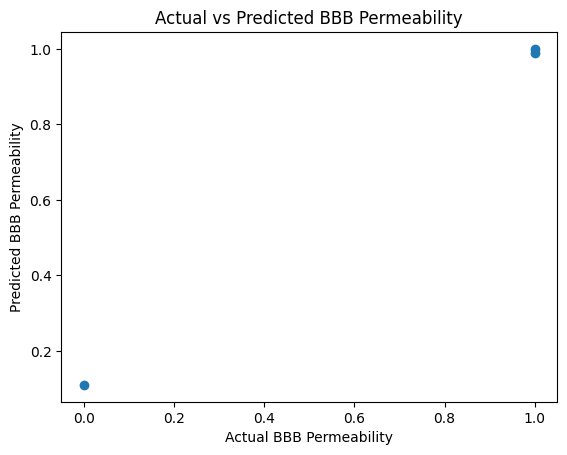

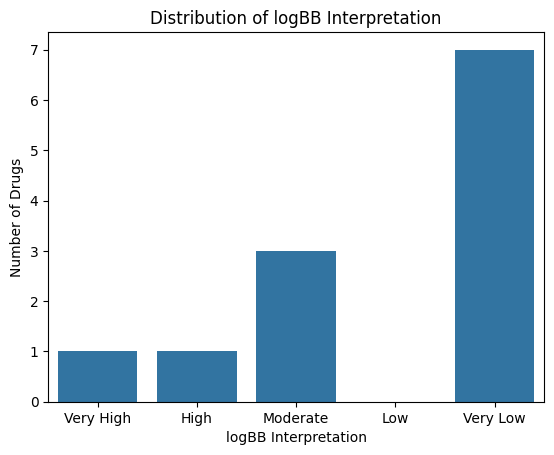

In [12]:
# Install required libraries
!pip install chembl_webresource_client rdkit scikit-learn pandas numpy seaborn matplotlib

# Import libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieve SMILES from ChEMBL
from chembl_webresource_client.new_client import new_client

# List of drugs
drugs = [
    "Tolnaftate", "Methotrexate", "Lisuride", "Vardenafil", "Fluspirilene",
    "Sofosbuvir", "Vorapaxar", "Olaparib", "Alatrofloxacin", "Lasmiditan",
    "Bictegravir", "Atogepant"
]

# Function to get SMILES from ChEMBL
def get_smiles(drug_name):
    try:
        molecule = new_client.molecule.filter(pref_name__iexact=drug_name).only('molecule_structures')[0]
        if molecule:
            return molecule['molecule_structures']['canonical_smiles']
        else:
            return None
    except Exception as e:
        print(f"Error retrieving SMILES for {drug_name}: {e}")
        return None

# Retrieve SMILES for each drug
drug_smiles = {}
for drug in drugs:
    smiles = get_smiles(drug)
    if smiles:
        drug_smiles[drug] = smiles
    else:
        print(f"SMILES not found for {drug}")

# Display the SMILES
for drug, smiles in drug_smiles.items():
    print(f"{drug}: {smiles}")

# Calculate molecular descriptors (LogP, TPSA, MW)
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    mw = Descriptors.MolWt(mol)
    return logp, tpsa, mw

# Create a DataFrame to store the data
data = []
for drug, smiles in drug_smiles.items():
    logp, tpsa, mw = calculate_descriptors(smiles)
    data.append([drug, smiles, logp, tpsa, mw])

df = pd.DataFrame(data, columns=["Drug", "SMILES", "LogP", "TPSA", "MW"])

# Estimate P-gp Efflux using rule-based method
def estimate_pgp_efflux(logp, tpsa):
    if logp > 4 and tpsa < 75:
        return 1  # Likely P-gp substrate
    else:
        return 0  # Not a P-gp substrate

# Estimate BBB Permeability using rule-based method
def estimate_bbb_permeability(logp, tpsa):
    if logp > 0 and tpsa < 90:
        return 1  # Likely BBB permeable
    else:
        return 0  # Not BBB permeable

# Apply the rules to the DataFrame
df["P-gp_Efflux"] = df.apply(lambda row: estimate_pgp_efflux(row["LogP"], row["TPSA"]), axis=1)
df["BBB_Permeability"] = df.apply(lambda row: estimate_bbb_permeability(row["LogP"], row["TPSA"]), axis=1)

# Compute logBB using empirical equation
def compute_logbb(logp, tpsa):
    return 0.152 * logp - 0.0148 * tpsa + 0.139

# Add logBB to the DataFrame
df["logBB"] = df.apply(lambda row: compute_logbb(row["LogP"], row["TPSA"]), axis=1)

# Function to interpret logBB into categories
def interpret_logbb(logbb):
    if logbb > 0.7:
        return "Very High"
    elif 0.3 < logbb <= 0.7:
        return "High"
    elif -0.3 < logbb <= 0.3:
        return "Moderate"
    elif -0.7 < logbb <= -0.3:
        return "Low"
    else:
        return "Very Low"

# Add logBB interpretation to the DataFrame
df["logBB_Interpretation"] = df["logBB"].apply(interpret_logbb)

# Display the final DataFrame
print(df[["Drug", "LogP", "TPSA", "MW", "P-gp_Efflux", "BBB_Permeability", "logBB", "logBB_Interpretation"]])

# Prepare the data for QSAR modeling
X = df[["LogP", "TPSA", "MW", "P-gp_Efflux"]]
y = df["BBB_Permeability"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Visualize the results
plt.scatter(y_test, y_pred)
plt.xlabel("Actual BBB Permeability")
plt.ylabel("Predicted BBB Permeability")
plt.title("Actual vs Predicted BBB Permeability")
plt.show()

# Plot the distribution of logBB Interpretation
sns.countplot(x="logBB_Interpretation", data=df, order=["Very High", "High", "Moderate", "Low", "Very Low"])
plt.title("Distribution of logBB Interpretation")
plt.xlabel("logBB Interpretation")
plt.ylabel("Number of Drugs")
plt.show()


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Tolnaftate: Cc1cccc(N(C)C(=S)Oc2ccc3ccccc3c2)c1
Methotrexate: CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1
Lisuride: CCN(CC)C(=O)N[C@H]1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1
Vardenafil: CCCc1nc(C)c2c(=O)nc(-c3cc(S(=O)(=O)N4CCN(CC)CC4)ccc3OCC)[nH]n12
Fluspirilene: O=C1NCN(c2ccccc2)C12CCN(CCCC(c1ccc(F)cc1)c1ccc(F)cc1)CC2
Sofosbuvir: CC(C)OC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@@H](n2ccc(=O)[nH]c2=O)[C@](C)(F)[C@@H]1O)Oc1ccccc1
Vorapaxar: CCOC(=O)N[C@@H]1CC[C@@H]2[C@@H](C1)C[C@H]1C(=O)O[C@H](C)[C@H]1[C@H]2/C=C/c1ccc(-c2cccc(F)c2)cn1
Olaparib: O=C(c1cc(Cc2n[nH]c(=O)c3ccccc23)ccc1F)N1CCN(C(=O)C2CC2)CC1
Alatrofloxacin: C[C@H](N)C(=O)N[C@@H](C)C(=O)N[C@H]1[C@@H]2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)cc3F)C[C@@H]21
Lasmiditan: CN1CCC(C(=O)c2cccc(NC(=O)c3c(F)cc(F)cc3F)n2)CC1
Bictegravir: O=C(NCc1c(F)cc(F)cc1F)c1cn2c(c(O)c1=O)C(=O)N1[C@H]3CC[C@H](C3)O[C@@H]1C2
Atogepan

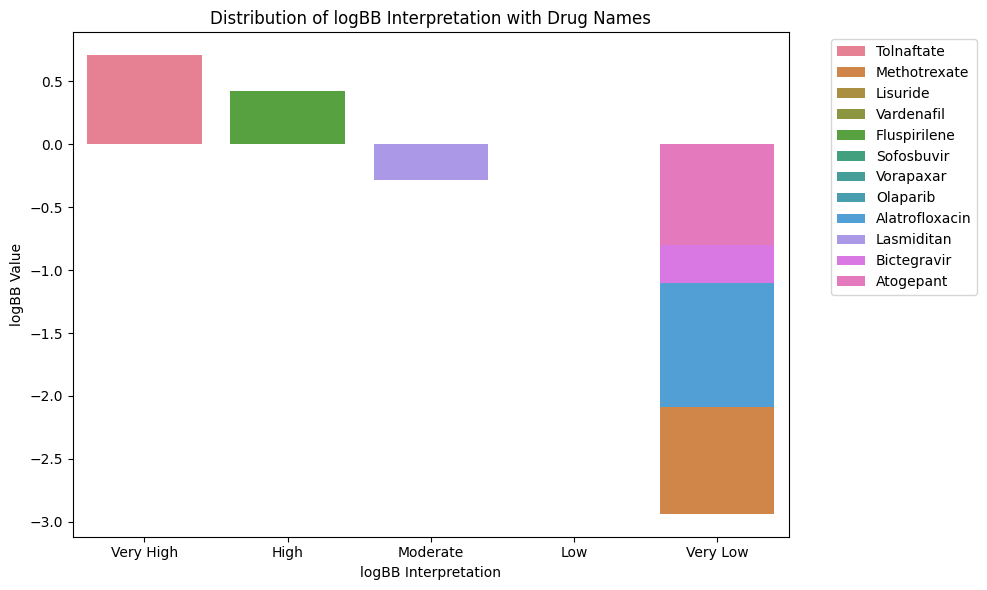

In [13]:
# Install required libraries
!pip install chembl_webresource_client rdkit scikit-learn pandas numpy seaborn matplotlib

# Import libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieve SMILES from ChEMBL
from chembl_webresource_client.new_client import new_client

# List of drugs
drugs = [
    "Tolnaftate", "Methotrexate", "Lisuride", "Vardenafil", "Fluspirilene",
    "Sofosbuvir", "Vorapaxar", "Olaparib", "Alatrofloxacin", "Lasmiditan",
    "Bictegravir", "Atogepant"
]

# Function to get SMILES from ChEMBL
def get_smiles(drug_name):
    try:
        molecule = new_client.molecule.filter(pref_name__iexact=drug_name).only('molecule_structures')[0]
        if molecule:
            return molecule['molecule_structures']['canonical_smiles']
        else:
            return None
    except Exception as e:
        print(f"Error retrieving SMILES for {drug_name}: {e}")
        return None

# Retrieve SMILES for each drug
drug_smiles = {}
for drug in drugs:
    smiles = get_smiles(drug)
    if smiles:
        drug_smiles[drug] = smiles
    else:
        print(f"SMILES not found for {drug}")

# Display the SMILES
for drug, smiles in drug_smiles.items():
    print(f"{drug}: {smiles}")

# Calculate molecular descriptors (LogP, TPSA, MW)
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    mw = Descriptors.MolWt(mol)
    return logp, tpsa, mw

# Create a DataFrame to store the data
data = []
for drug, smiles in drug_smiles.items():
    logp, tpsa, mw = calculate_descriptors(smiles)
    data.append([drug, smiles, logp, tpsa, mw])

df = pd.DataFrame(data, columns=["Drug", "SMILES", "LogP", "TPSA", "MW"])

# Estimate P-gp Efflux using rule-based method
def estimate_pgp_efflux(logp, tpsa):
    if logp > 4 and tpsa < 75:
        return 1  # Likely P-gp substrate
    else:
        return 0  # Not a P-gp substrate

# Estimate BBB Permeability using rule-based method
def estimate_bbb_permeability(logp, tpsa):
    if logp > 0 and tpsa < 90:
        return 1  # Likely BBB permeable
    else:
        return 0  # Not BBB permeable

# Apply the rules to the DataFrame
df["P-gp_Efflux"] = df.apply(lambda row: estimate_pgp_efflux(row["LogP"], row["TPSA"]), axis=1)
df["BBB_Permeability"] = df.apply(lambda row: estimate_bbb_permeability(row["LogP"], row["TPSA"]), axis=1)

# Compute logBB using empirical equation
def compute_logbb(logp, tpsa):
    return 0.152 * logp - 0.0148 * tpsa + 0.139

# Add logBB to the DataFrame
df["logBB"] = df.apply(lambda row: compute_logbb(row["LogP"], row["TPSA"]), axis=1)

# Function to interpret logBB into categories
def interpret_logbb(logbb):
    if logbb > 0.7:
        return "Very High"
    elif 0.3 < logbb <= 0.7:
        return "High"
    elif -0.3 < logbb <= 0.3:
        return "Moderate"
    elif -0.7 < logbb <= -0.3:
        return "Low"
    else:
        return "Very Low"

# Add logBB interpretation to the DataFrame
df["logBB_Interpretation"] = df["logBB"].apply(interpret_logbb)

# Display the final DataFrame
print(df[["Drug", "LogP", "TPSA", "MW", "P-gp_Efflux", "BBB_Permeability", "logBB", "logBB_Interpretation"]])

# Plot the distribution of logBB Interpretation with drug names
plt.figure(figsize=(10, 6))
sns.barplot(x="logBB_Interpretation", y="logBB", hue="Drug", data=df, order=["Very High", "High", "Moderate", "Low", "Very Low"], dodge=False)
plt.title("Distribution of logBB Interpretation with Drug Names")
plt.xlabel("logBB Interpretation")
plt.ylabel("logBB Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

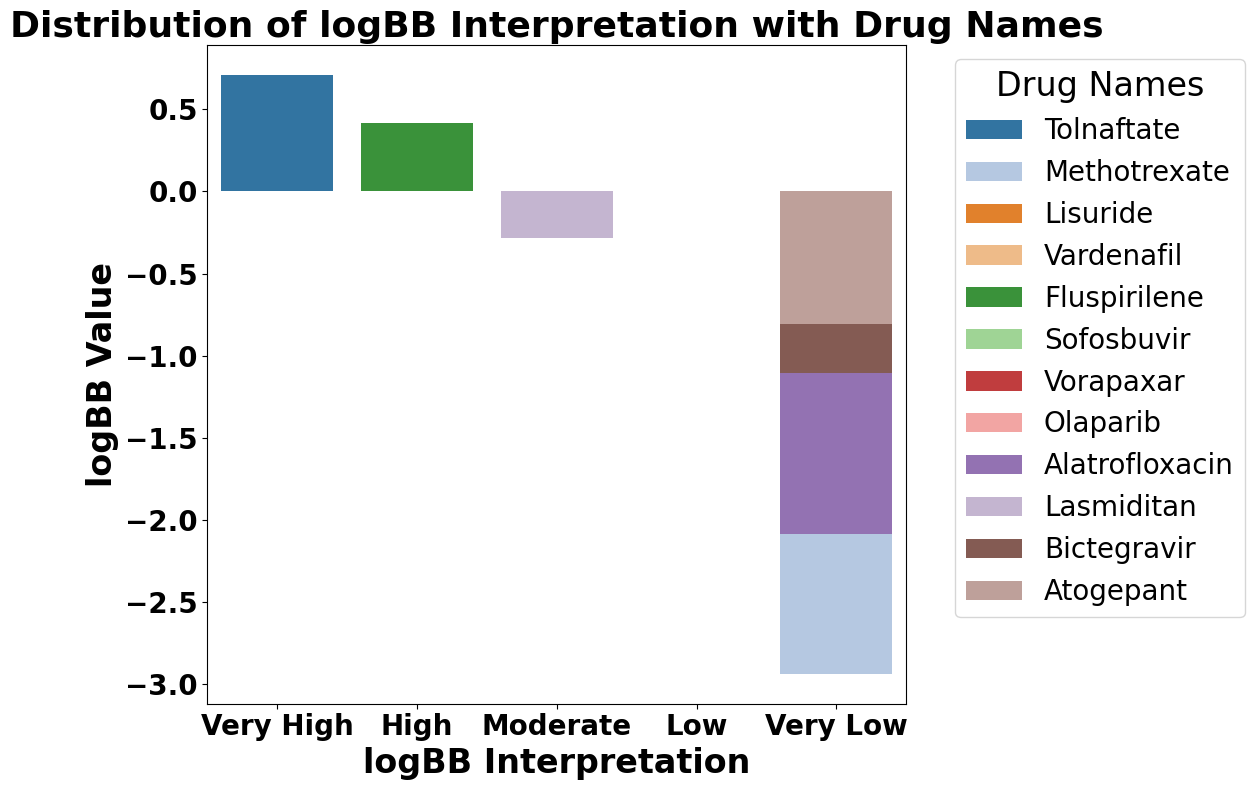

In [14]:
# Plot the distribution of logBB Interpretation with drug names
plt.figure(figsize=(12, 8))

# Create a bar plot with unique colors for each drug
sns.barplot(
    x="logBB_Interpretation", 
    y="logBB", 
    hue="Drug", 
    data=df, 
    palette="tab20",  # Use a color palette with distinct colors
    order=["Very High", "High", "Moderate", "Low", "Very Low"], 
    dodge=False
)

# Add title and labels with bold and bigger fonts
plt.title("Distribution of logBB Interpretation with Drug Names", fontsize=26, fontweight='bold')
plt.xlabel("logBB Interpretation", fontsize=24, fontweight='bold')
plt.ylabel("logBB Value", fontsize=24, fontweight='bold')

# Customize tick labels
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

# Move legend outside the plot and make it bigger
plt.legend(
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    fontsize=20, 
    title="Drug Names", 
    title_fontsize=24
)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [27]:
df.to_csv("nbbb_predictions.csv", index=False)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
              Drug     LogP    TPSA       MW  pKa      LogD
0       Tolnaftate  4.94832   12.47  307.418  8.4  3.906927
1     Methotrexate  0.26840  210.54  454.447  5.5  0.262967
2         Lisuride  2.84140   51.37  338.455  7.8  2.295860
3       Vardenafil  2.07042  112.90  488.614  6.4  2.029027
4     Fluspirilene  5.30540   35.58  475.583  8.2  4.441508
5       Sofosbuvir  1.65650  158.18  529.458  9.1 -0.052080
6        Vorapaxar  5.62950   77.52  492.591  5.9  5.615979
7         Olaparib  2.34740   86.37  434.471  7.2  2.134957
8   Alatrofloxacin  0.90390  159.65  558.517  6.1  0.882662
9       Lasmiditan  3.27570   62.30  377.366  8.0  2.578377
10     Bictegravir  1.63440  100.87  449.385  6.8  1.537077
11       Atogepant  3.94790  104.29  603.523  7.5  3.593998


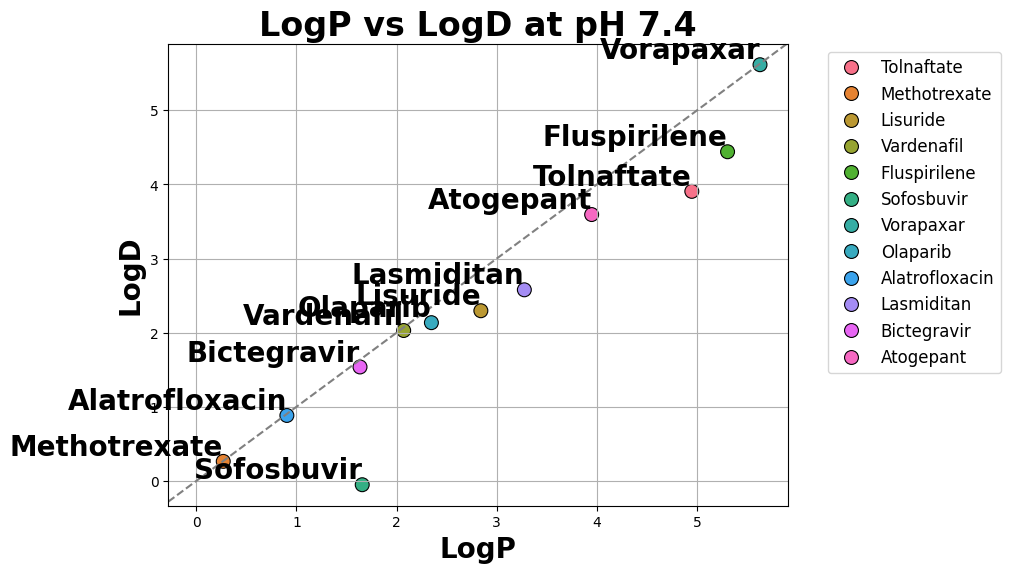

In [15]:
# Install required libraries
!pip install chembl_webresource_client rdkit scikit-learn pandas numpy seaborn matplotlib

# Import libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
import seaborn as sns
import matplotlib.pyplot as plt
from chembl_webresource_client.new_client import new_client

# List of drugs
drugs = [
    "Tolnaftate", "Methotrexate", "Lisuride", "Vardenafil", "Fluspirilene",
    "Sofosbuvir", "Vorapaxar", "Olaparib", "Alatrofloxacin", "Lasmiditan",
    "Bictegravir", "Atogepant"
]

# Function to get SMILES from ChEMBL
def get_smiles(drug_name):
    try:
        molecule = new_client.molecule.filter(pref_name__iexact=drug_name).only('molecule_structures')[0]
        if molecule:
            return molecule['molecule_structures']['canonical_smiles']
        else:
            return None
    except Exception as e:
        print(f"Error retrieving SMILES for {drug_name}: {e}")
        return None

# Retrieve SMILES for each drug
drug_smiles = {drug: get_smiles(drug) for drug in drugs if get_smiles(drug)}

# Function to calculate molecular descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        mw = Descriptors.MolWt(mol)
        return logp, tpsa, mw
    return None, None, None

# Function to calculate LogD at pH 7.4
def calculate_logD(logp, pKa, pH=7.4):
    return logp - np.log10(1 + 10 ** (pKa - pH)) if pKa is not None else logp

# Estimated pKa values for the drugs (can be replaced with experimental values)
pKa_values = {
    "Tolnaftate": 8.4, "Methotrexate": 5.5, "Lisuride": 7.8, "Vardenafil": 6.4,
    "Fluspirilene": 8.2, "Sofosbuvir": 9.1, "Vorapaxar": 5.9, "Olaparib": 7.2,
    "Alatrofloxacin": 6.1, "Lasmiditan": 8.0, "Bictegravir": 6.8, "Atogepant": 7.5
}

# Create a DataFrame to store the data
data = []
for drug, smiles in drug_smiles.items():
    logp, tpsa, mw = calculate_descriptors(smiles)
    pKa = pKa_values.get(drug, None)
    logD = calculate_logD(logp, pKa)
    data.append([drug, smiles, logp, tpsa, mw, pKa, logD])

df = pd.DataFrame(data, columns=["Drug", "SMILES", "LogP", "TPSA", "MW", "pKa", "LogD"])

# Display the final DataFrame
print(df[["Drug", "LogP", "TPSA", "MW", "pKa", "LogD"]])

# Save to CSV
df.to_csv("logD_calculations.csv", index=False)

# Plot LogP vs LogD
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["LogP"], y=df["LogD"], hue=df["Drug"], s=100, edgecolor="black")

# Add drug names at their respective points
for i, row in df.iterrows():
    plt.text(row["LogP"], row["LogD"], row["Drug"], fontsize=20, fontweight='bold', ha='right', va='bottom')

plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.title("LogP vs LogD at pH 7.4", fontsize=24, fontweight='bold')
plt.xlabel("LogP", fontsize=20, fontweight='bold')
plt.ylabel("LogD", fontsize=20, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=12, loc='upper left')
plt.grid(True)
plt.show()


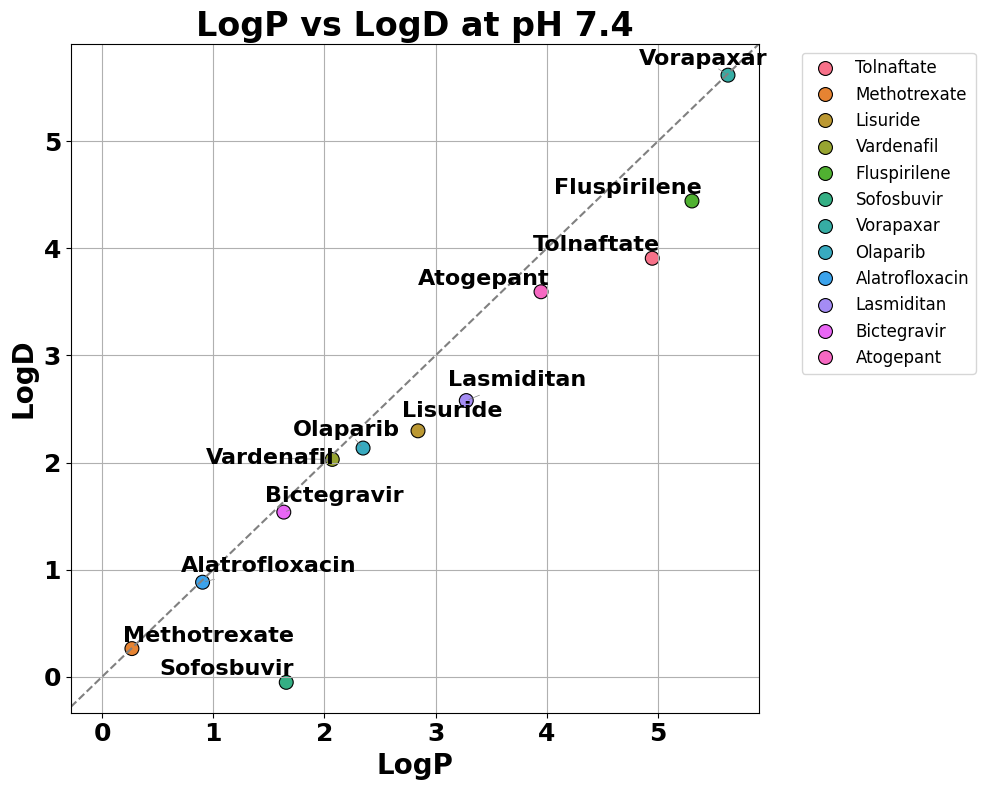

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import pandas as pd  # Import pandas if not already imported

# Assuming df is your DataFrame
# Example DataFrame (replace with your actual data)
data = {
    "Drug": ["Tolnaftate", "Methotrexate", "Lisuride", "Vardenafil", "Fluspirilene", "Sofosbuvir", "Vorapaxar", "Olaparib", "Alatrofloxacin", "Lasmiditan", "Bictegravir", "Atogepant"],
    "LogP": [4.94832, 0.26840, 2.84140, 2.07042, 5.30540, 1.65650, 5.62950, 2.34740, 0.90390, 3.27570, 1.63440, 3.94790],
    "LogD": [3.906927, 0.262967, 2.295860, 2.029027, 4.441508, -0.052080, 5.615979, 2.134957, 0.882662, 2.578377, 1.537077, 3.593998]
}
df = pd.DataFrame(data)

# Plot 1: LogP vs LogD
plt.figure(figsize=(10, 8)) # increased figure size
sns.scatterplot(x=df["LogP"], y=df["LogD"], hue=df["Drug"], s=100, edgecolor="black")

# Add drug names at their respective points
texts = []
for i, row in df.iterrows():
    texts.append(plt.text(row["LogP"], row["LogD"], row["Drug"], fontsize=16, fontweight='bold', ha='right', va='bottom')) # reduced fontsize

# Adjust text positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5, shrinkA=10))  # Increased shrinkA to 10

# Adjust text positions to avoid overlap
#adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5), force_points=0.2) # added force_points

plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.title("LogP vs LogD at pH 7.4", fontsize=24, fontweight='bold')
plt.xlabel("LogP", fontsize=20, fontweight='bold')
plt.ylabel("LogD", fontsize=20, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=12, loc='upper left')
plt.grid(True)
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.tight_layout() # Added to prevent overlap of plot elements.
plt.show()

In [21]:
from rdkit.Chem import Crippen  # Import Crippen module for ClogP calculation

# Function to calculate molecular descriptors including ClogP
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        clogp = Crippen.MolLogP(mol)  # Calculate ClogP using Wildman-Crippen method
        tpsa = Descriptors.TPSA(mol)
        mw = Descriptors.MolWt(mol)
        return clogp, tpsa, mw
    return None, None, None

# Update DataFrame creation to use ClogP
data = []
for drug, smiles in drug_smiles.items():
    clogp, tpsa, mw = calculate_descriptors(smiles)
    pKa = pKa_values.get(drug, None)
    logD = calculate_logD(clogp, pKa)  # Use ClogP for LogD calculation
    data.append([drug, smiles, clogp, tpsa, mw, pKa, logD])

df = pd.DataFrame(data, columns=["Drug", "SMILES", "ClogP", "TPSA", "MW", "pKa", "LogD"])

# Display the updated DataFrame
print(df[["Drug", "ClogP", "TPSA", "MW", "pKa", "LogD"]])


              Drug    ClogP    TPSA       MW  pKa      LogD
0       Tolnaftate  4.94832   12.47  307.418  8.4  3.906927
1     Methotrexate  0.26840  210.54  454.447  5.5  0.262967
2         Lisuride  2.84140   51.37  338.455  7.8  2.295860
3       Vardenafil  2.07042  112.90  488.614  6.4  2.029027
4     Fluspirilene  5.30540   35.58  475.583  8.2  4.441508
5       Sofosbuvir  1.65650  158.18  529.458  9.1 -0.052080
6        Vorapaxar  5.62950   77.52  492.591  5.9  5.615979
7         Olaparib  2.34740   86.37  434.471  7.2  2.134957
8   Alatrofloxacin  0.90390  159.65  558.517  6.1  0.882662
9       Lasmiditan  3.27570   62.30  377.366  8.0  2.578377
10     Bictegravir  1.63440  100.87  449.385  6.8  1.537077
11       Atogepant  3.94790  104.29  603.523  7.5  3.593998


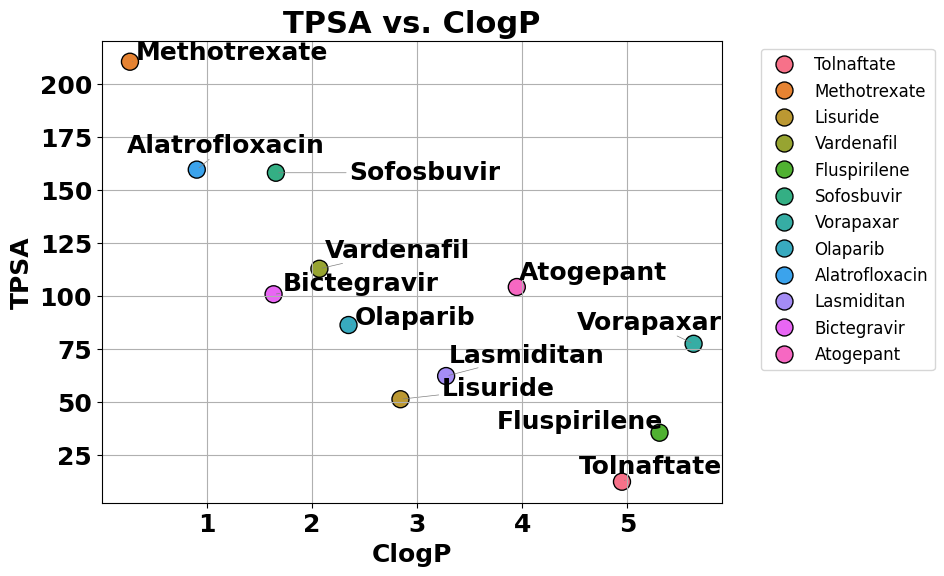

In [22]:
from adjustText import adjust_text

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["ClogP"], y=df["TPSA"], hue=df["Drug"], s=150, edgecolor="black")

# Add drug names at their respective points with automatic adjustment
texts = []
for i, row in df.iterrows():
    texts.append(plt.text(row["ClogP"], row["TPSA"], row["Drug"], fontsize=18, fontweight='bold'))

# Adjust text positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Customize tick labels
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

plt.title("TPSA vs. ClogP", fontsize=22, fontweight='bold')
plt.xlabel("ClogP", fontsize=18, fontweight='bold')
plt.ylabel("TPSA", fontsize=18, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=12, loc='upper left')
plt.grid(True)
plt.show()


In [24]:
print(df.columns)


Index(['Drug', 'SMILES', 'ClogP', 'TPSA', 'MW', 'pKa', 'LogD'], dtype='object')


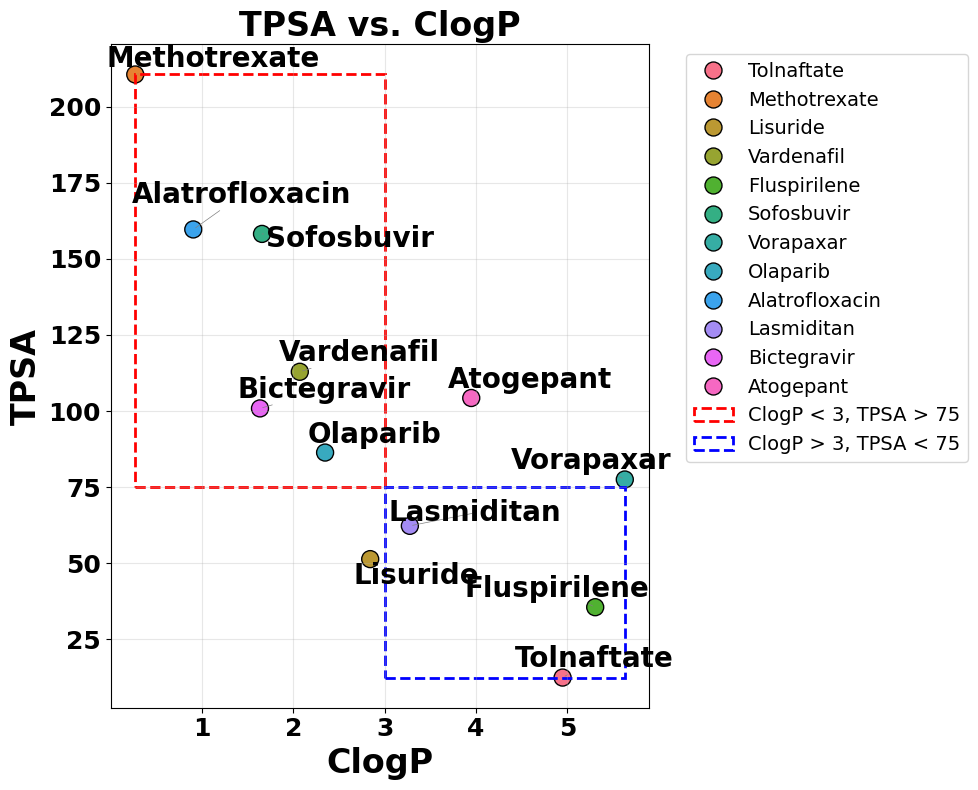

In [29]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# Create the scatter plot
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    x=df["ClogP"],  # <-- Changed to "ClogP"
    y=df["TPSA"], 
    hue=df["Drug"], 
    s=150, 
    edgecolor="black"
)

# Add drug labels
texts = []
for i, row in df.iterrows():
    texts.append(
        plt.text(
            row["ClogP"],  # <-- Changed to "ClogP"
            row["TPSA"], 
            row["Drug"], 
            fontsize=20, 
            fontweight='bold'
        )
    )
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# --- Box Calculations (Updated for ClogP) ---
x_min, x_max = df["ClogP"].min(), df["ClogP"].max()
y_min, y_max = df["TPSA"].min(), df["TPSA"].max()

# Box 1: ClogP < 3 AND TPSA > 75 (Red dashed)
rect1 = patches.Rectangle(
    (x_min, 75),       # Bottom-left corner at (min_ClogP, 75)
    width=3 - x_min,   # Width spans from min_ClogP to 3
    height=y_max - 75, # Height spans from 75 to max_TPSA
    linewidth=2,
    edgecolor='red',
    facecolor='none',
    linestyle="dashed"
)

# Box 2: ClogP > 3 AND TPSA < 75 (Blue dashed)
rect2 = patches.Rectangle(
    (3, y_min),        # Bottom-left corner at (3, min_TPSA)
    width=x_max - 3,   # Width spans from 3 to max_ClogP
    height=75 - y_min, # Height spans from min_TPSA to 75
    linewidth=2,
    edgecolor='blue',
    facecolor='none',
    linestyle="dashed"
)

ax.add_patch(rect1)
ax.add_patch(rect2)

# --- Styling & Labels ---
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.title("TPSA vs. ClogP", fontsize=24, fontweight='bold')  # Updated title
plt.xlabel("ClogP", fontsize=24, fontweight='bold')  # <-- Changed to "ClogP"
plt.ylabel("TPSA", fontsize=24, fontweight='bold')

# --- Legend Handling ---
handles, labels = ax.get_legend_handles_labels()

# Add rectangles to legend
handles.extend([rect1, rect2])
labels.extend([
    "ClogP < 3, TPSA > 75",  # <-- Updated label
    "ClogP > 3, TPSA < 75"   # <-- Updated label
])

# Remove duplicates while preserving order
seen = set()
unique_handles = []
unique_labels = []
for h, l in zip(handles, labels):
    if l not in seen:
        seen.add(l)
        unique_handles.append(h)
        unique_labels.append(l)

plt.legend(
    unique_handles,
    unique_labels,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=14
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

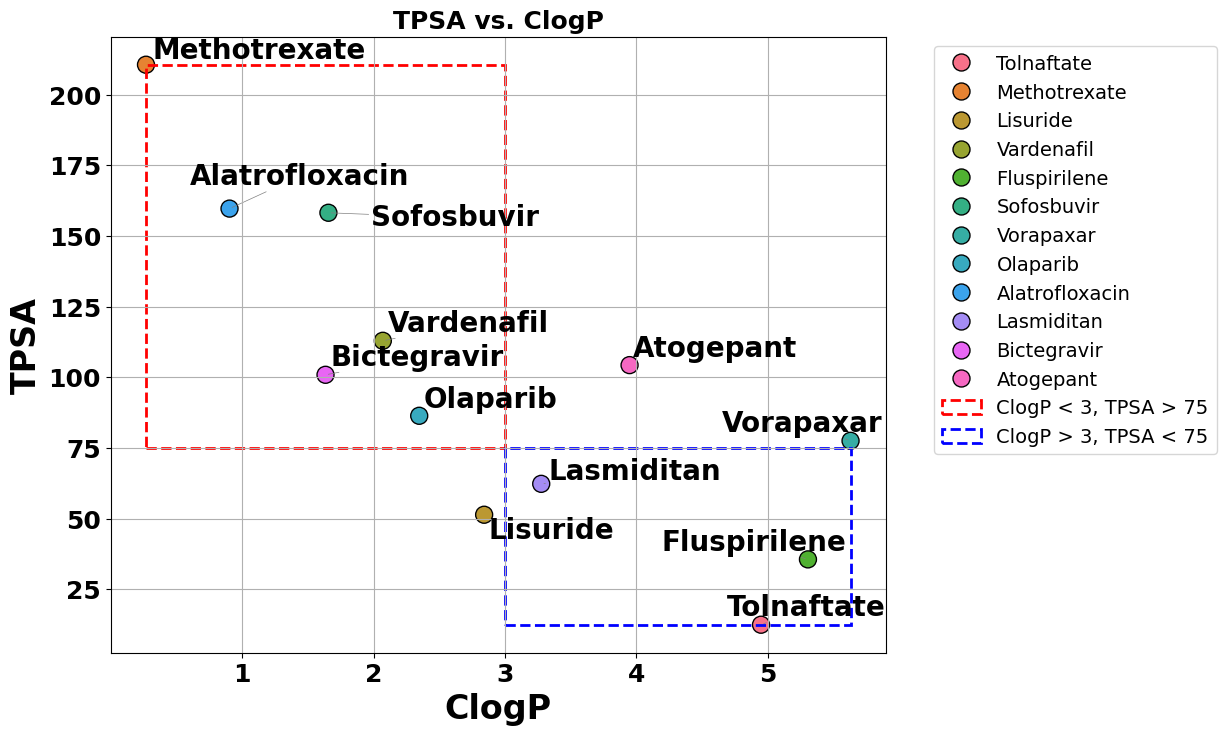

In [30]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# Create the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df["ClogP"], y=df["TPSA"], hue=df["Drug"], s=150, edgecolor="black")

# Add drug names at their respective points with automatic adjustment
texts = []
for i, row in df.iterrows():
    texts.append(plt.text(row["ClogP"], row["TPSA"], row["Drug"], fontsize=20, fontweight='bold'))

# Adjust text positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Box 1: Highlighting region where ClogP < 3 and TPSA > 75 (Red dashed)
rect1 = patches.Rectangle((min(df["ClogP"]), 75), 3 - min(df["ClogP"]), max(df["TPSA"]) - 75, 
                          linewidth=2, edgecolor='red', facecolor='none', linestyle="dashed")
plt.gca().add_patch(rect1)

# Box 2: Highlighting region where ClogP > 3 and TPSA < 75 (Blue dashed)
rect2 = patches.Rectangle((3, min(df["TPSA"])), max(df["ClogP"]) - 3, 75 - min(df["TPSA"]), 
                          linewidth=2, edgecolor='blue', facecolor='none', linestyle="dashed")
plt.gca().add_patch(rect2)

# Customize tick labels
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

plt.title("TPSA vs. ClogP", fontsize=18, fontweight='bold')
plt.xlabel("ClogP", fontsize=24, fontweight='bold')
plt.ylabel("TPSA", fontsize=24, fontweight='bold')

# Get existing legend handles & labels (for drugs)
handles, labels = plt.gca().get_legend_handles_labels()

# Add new legend entries for the boxes
handles.extend([rect1, rect2])
labels.extend(["ClogP < 3, TPSA > 75", "ClogP > 3, TPSA < 75"])

# Remove duplicate labels by converting to a dictionary
unique_legend = dict(zip(labels, handles))

# Re-apply unique legend
plt.legend(unique_legend.values(), unique_legend.keys(), bbox_to_anchor=(1.05, 1), fontsize=14, loc='upper left')

plt.grid(True)
plt.show()
